# model 3

In [2]:
from abc import ABC
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
from preprocessing import SentencesEmbeddingDataset
from model2_nn import train_and_plot
from torch.nn.utils import rnn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim import Adam
from train_loop_model3 import train_and_plot_LSTM
from utils import remove_padding
from model3_comp import LSTM_NER_NN
from utils import print_epoch_details, remove_padding
from torch.nn.functional import one_hot

In [3]:
ds = SentencesEmbeddingDataset(vec_dim=300, 
                               embedding_model_path="word2vec-google-news-300"
                            #    list_embedding_paths=['glove-twitter-200', 'word2vec-google-news-300'],
                            #    list_vec_dims=[200, 300]
                               )

preparing embedding...


In [5]:
ds.vec_dim=300

In [6]:
batch_size = 32
train_loader, dev_loader = ds.get_data_loaders(batch_size=batch_size)

C:\Users\YaelH\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


No GPU available, training on CPU.
Epoch: 1/10 | train Accuracy: 0.927 | train F1: 0.445
Epoch: 1/10 | validate Accuracy: 0.894 | validate F1: 0.541
Epoch: 2/10 | train Accuracy: 0.934 | train F1: 0.558
Epoch: 2/10 | validate Accuracy: 0.931 | validate F1: 0.622
Epoch: 3/10 | train Accuracy: 0.947 | train F1: 0.621
Epoch: 3/10 | validate Accuracy: 0.917 | validate F1: 0.599
Epoch: 4/10 | train Accuracy: 0.957 | train F1: 0.674
Epoch: 4/10 | validate Accuracy: 0.939 | validate F1: 0.648
Epoch: 5/10 | train Accuracy: 0.965 | train F1: 0.720
Epoch: 5/10 | validate Accuracy: 0.946 | validate F1: 0.660
Epoch: 6/10 | train Accuracy: 0.967 | train F1: 0.732
Epoch: 6/10 | validate Accuracy: 0.946 | validate F1: 0.657
Epoch: 7/10 | train Accuracy: 0.971 | train F1: 0.762
Epoch: 7/10 | validate Accuracy: 0.947 | validate F1: 0.658
Epoch: 8/10 | train Accuracy: 0.976 | train F1: 0.797
Epoch: 8/10 | validate Accuracy: 0.950 | validate F1: 0.663
Epoch: 9/10 | train Accuracy: 0.979 | train F1: 0.819

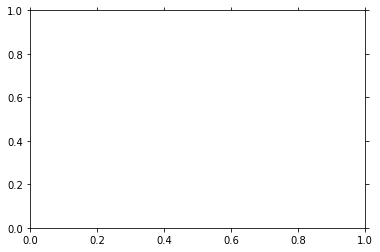

In [ ]:
from model3_comp import main
main()
# run(
#     NER_dataset=ds,
#     embedding_name="concated",
#     vec_dim=500,
#     hidden_dim=256,
#     dropout=0.4,
#     class_weights=torch.tensor([0.1, 0.9]),
#     loss_func=nn.CrossEntropyLoss(weight=torch.tensor([0.1, 0.9])),
#     loss_func_name='CrossEntropy',
# )

# max_pull

In [15]:
# pool of square window of size=3, stride=2
m = nn.MaxPool1d(2, stride=2)
# pool of non-square window
# m = nn.MaxPool2d((3, 2))
input = torch.randn(32, 128)
output = m(input)

In [16]:
input.size(), output.size()

(torch.Size([32, 128]), torch.Size([32, 64]))

# data

In [130]:
import pandas as pd
df = pd.read_csv('data/ner.csv')
df = df.drop('POS', 1)
df['Sentence'] = df['Sentence'].apply(lambda x: x.split())
df['Tag'] = df['Tag'].apply(lambda x: x.strip("[]").replace("'", '').split(', '))
df['len_sent'] = df['Sentence'].apply(lambda x: len(x))
df['len_tag'] = df['Tag'].apply(lambda x: len(x))
mask = (df['len_sent'] == df['len_tag'])
df = df[mask]
df = df.drop([
    5699, 8331, 9158, 26395, 26399, 28978, 29163, 31422, 31423, 31426, 31427, 
    33653, 34217, 34220, 39286, 39290, 43339, 47182
])

with open('data/my_dataset', 'w') as f:
    for i in df.iterrows():
        for word, tag in zip(i[1]['Sentence'], i[1]['Tag']):
            f.write(f'{str(word)}\t{tag}\n')
        f.write('\n')

In [131]:
i[0]

47958

In [132]:
len(df)

47937